## Quantum authentication protocol
Quantum authentication protocol. In 2002, Barnum et al. introduced a quantum authentication protocol that uses tag qubits to ensure the authenticity of a transmitted message. A practical version of the protocol, suitable for implementation, is illustrated in the figure.
![QuantumAuthenticationProtocol](images/QuantumAuthenticationProtocol.png)

1. **Message preparation**  
   Alice encodes an $n$-bit classical message (e.g., $110 \mapsto \lvert 110\rangle$) in the message register `q_msg`.  

2. **Shared key**  
   Alice and Bob agree on a classical secret key of length $k = 3n$. Each triplet of key bits $(k_1,k_2,k_3)$ specifies which gates are applied to the corresponding message qubit:  
   - $k_1=1 \;\Rightarrow\; X$  
   - $k_2=1 \;\Rightarrow\; Z$  
   - $k_3=1 \;\Rightarrow\; H$  

3. **Tag creation**  
   Each message qubit is entangled with a tag qubit via a CNOT, forming the tag register `q_tag`. The entanglement creates strong correlations that enable tamper detection.  

4. **Transmission and tampering**  
   The combined state (`q_msg`, `q_tag`) is transmitted to Bob. Tampering can be modeled as random $X$ errors on selected qubits.  

5. **Bob’s verification**  
   - He reverses the CNOT entanglement.  
   - Using the shared key, he applies the inverse gates in reverse order.  
   - Finally, he measures both registers. If all tag qubits are in state $\lvert 0\rangle$, the message is accepted; otherwise, it is rejected.  

6. **Redundancy**  
   A message qubit may be entangled with multiple tag qubits, so tampering is likely to disturb several of them, increasing detection probability.  

### Task

- Implement the quantum authentication protocol in Qiskit as a **single quantum circuit**, where Alice encodes and sends the message and Bob performs the verification.  
- Model tampering or transmission errors by introducing random bit flips (X gates) on one or more qubits **after Alice has sent the message but before Bob’s verification step**.  
- To enhance detection sensitivity, entangle each message qubit with **multiple tag qubits**, so that any disturbance to the message is more likely to be revealed during verification.  

### Experimentation

- Vary the length of the shared key and observe how it affects the encoding and decoding steps.  
- Try different numbers of tag qubits per message qubit and compare the likelihood of detecting tampering.  
- Introduce controlled tampering: flip a specific qubit and verify whether Bob detects the error.  
- Simulate noise channels (e.g., bit-flip or depolarizing) instead of simple X errors to model more realistic transmission errors.  
- Measure the acceptance rate of messages over multiple runs to estimate the protocol’s robustness against tampering.  


Shared key: [0 0 0 0 1 0]
Tampering: Flipping message qubit 1


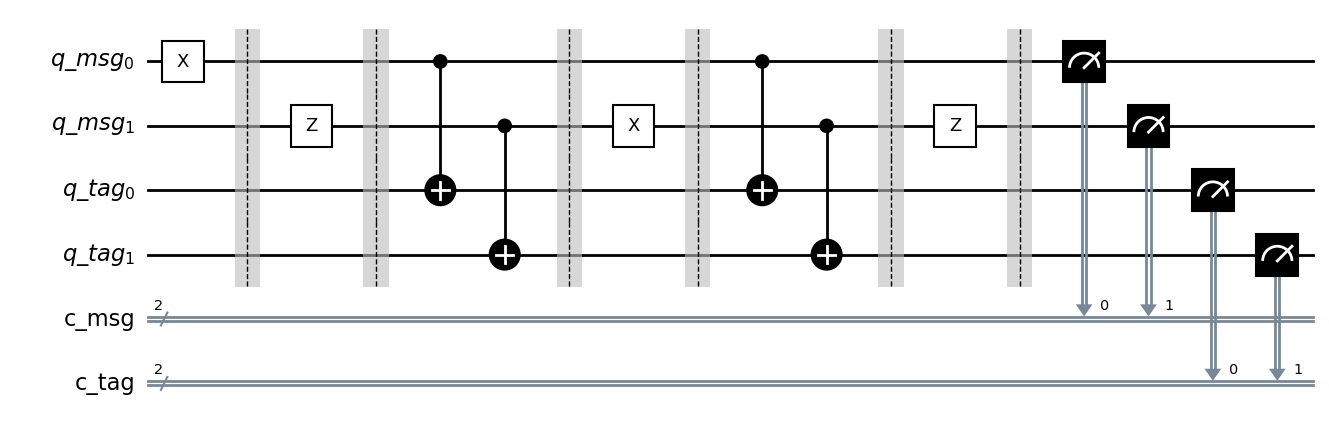

Measurement output: {'10 11': 1024}
Message sent: 10     Message received: 11     Tag measurement: 10
Tampering detected: Message rejected.


In [7]:
from IPython.display import display

from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import circuit_drawer
import numpy as np

#-- parameters --
alice_message = '10'
n = len(alice_message) # number of message qubits
k = 3 * n              # key length (3 bits per qubit)
m = 1                  # number of tag qubits per message qubit
num_tag_qubits = n * m # total tag qubits 
t = 1                  # number of tampering events

# shared secret key (randomly generated for simulation)
key = np.random.randint(0, 2, k)
print(f"Shared key: {key}")

#-- initialize registers --
q_msg = QuantumRegister(n, 'q_msg')               # message qubits
q_tag = QuantumRegister(num_tag_qubits, 'q_tag')  # tag qubits
c_msg = ClassicalRegister(n, 'c_msg')             # message measurement register
c_tag = ClassicalRegister(num_tag_qubits, 'c_tag') # tag measurement register
qc = QuantumCircuit(q_msg, q_tag, c_msg, c_tag)

#-- step 1: Alice prepares a  message --
# initialize message qubits from classical bits
for i, bit in enumerate(alice_message):
    if bit == '1':
        qc.x(q_msg[i])
qc.barrier()

#-- step 2: Alice encodes each message qubit based on the key triplet --
for i in range(n):
    key_triplet = key[3*i:3*(i+1)]  # get triplet for i-th qubit
    if key_triplet[0] == 1:  # Apply X if k_1 = 1
        qc.x(q_msg[i])
    if key_triplet[1] == 1:  # Apply Z if k_2 = 1
        qc.z(q_msg[i])
    if key_triplet[2] == 1:  # Apply H if k_3 = 1
        qc.h(q_msg[i])
qc.barrier()

#-- step 3: Alice entangles each message qubit with its tag qubit --
for i in range(n):
    for j in range(m):
        qc.cx(q_msg[i], q_tag[i * m + j])
qc.barrier()

# ------- transmission lines -------

# Step 4: Simulate tampering by flipping t random qubits (message or tag)
tamper_qubits = np.random.choice(n + num_tag_qubits, size=t, replace=False)
for tamper_qubit in tamper_qubits:
    if tamper_qubit < n:
        print(f"Tampering: Flipping message qubit {tamper_qubit}")
        qc.x(q_msg[tamper_qubit])
    else:
        tag_idx = tamper_qubit - n
        print(f"Tampering: Flipping tag qubit {tag_idx}")
        qc.x(q_tag[tag_idx])
qc.barrier()

# ------- transmission lines -------

#-- step 5: Bob reverses the entanglement by applying CNOT --
for i in range(n):
    for j in range(m):
        qc.cx(q_msg[i], q_tag[i * m + j])
qc.barrier()

#-- step 6: Bob decodes message using the inverse gates in reverse order --
for i in range(n):
    key_triplet = key[3*i:3*(i+1)]  # Get triplet for i-th qubit
    if key_triplet[2] == 1:  # Apply H^-1 = H if k_3 = 1
        qc.h(q_msg[i])
    if key_triplet[1] == 1:  # Apply Z^-1 = Z if k_2 = 1
        qc.z(q_msg[i])
    if key_triplet[0] == 1:  # Apply X^-1 = X if k_1 = 1
        qc.x(q_msg[i])
qc.barrier()

#-- step 7: Bob measures the message and tag qubits --
qc.measure(q_msg, c_msg)
qc.measure(q_tag, c_tag)
display(circuit_drawer(qc, style="bw", output="mpl"))

#-- step 8: Simulate the circuit --
simulator = AerSimulator()
result = simulator.run(qc).result()
counts = result.get_counts(qc)

#-- step 9: extract results --
print(f"Measurement output: {counts}")
tag_measurement, msg_measurement = list(counts.keys())[0].split(' ', 1)
msg_measurement = msg_measurement [::-1] # little endian -> big endian

print(f"Message sent: {alice_message} \
    Message received: {msg_measurement} \
    Tag measurement: {tag_measurement}")
if '1' in tag_measurement:
    print("Tampering detected: Message rejected.")
else:
    print("No tampering detected: Message accepted.")